## Setup

Import the required libraries and initialize them:

In [1]:
from std_srvs.srv import Empty, Trigger, TriggerRequest


In [2]:
from cv_bridge import CvBridge, CvBridgeError
import rospy
#import cv2
import ros_numpy
import numpy as np
from tmc_tabletop_segmentator.srv import TabletopSegmentation
from tmc_tabletop_segmentator.srv import TabletopSegmentationRequest
from sensor_msgs.msg import Image
from std_msgs.msg import String
import tf
import tf2_ros
import geometry_msgs.msg
from utils_notebooks import *


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import ros_numpy
import rospy
import tf
from gazebo_ros import gazebo_interface
from sensor_msgs.msg import LaserScan, PointCloud2
from geometry_msgs.msg import Pose, Quaternion ,TransformStamped
import moveit_commander
import moveit_msgs.msg

import sys

from utils_notebooks import *
#from utils_task1 import *
import cv2
import os

# REMEMBER TO RUN MOVEIT 
# roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [4]:


cv2.__version__

## CHECK  CV VERSIONS IN CASE YOU WONT USE SURF 
## 3.3.1 is an old dependence use sys path remove if needed


'3.3.1-dev'

In [5]:
#! roslaunch  hsrb_moveit_config  hsrb_demo_with_controller.launch

In [6]:


bridge = CvBridge()
###might take some time to load all those takeshi meshes in rviz

head = moveit_commander.MoveGroupCommander('head')
arm = moveit_commander.MoveGroupCommander('arm')
whole_body = moveit_commander.MoveGroupCommander('whole_body_light')
whole_body.set_workspace([-6.0, -6.0, 6.0, 6.0])#whole_body.go(wb)


In [7]:
def rot_to_euler(R):
    import sys
    import math as m
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats

In [8]:
def rot_to_euler(R):
    import sys
    tol = sys.float_info.epsilon * 10

    if abs(R.item(0,0))< tol and abs(R.item(1,0)) < tol:
       eul1 = 0
       eul2 = m.atan2(-R.item(2,0), R.item(0,0))
       eul3 = m.atan2(-R.item(1,2), R.item(1,1))
    else:   
       eul1 = m.atan2(R.item(1,0),R.item(0,0))
       sp = m.sin(eul1)
       cp = m.cos(eul1)
       eul2 = m.atan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0))
       eul3 = m.atan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1))

    return np.asarray((eul1,eul2,eul3))
def pca_xyz(xyz):
    quats=[]
    for i in range( len(xyz)):
        pca= PCA(n_components=3).fit(xyz[i])
        vec0= pca.components_[0,:]
        vec1= pca.components_[1,:]
        vec2= pca.components_[2,:]
        R=pca.components_
        euler=rot_to_euler(R)
        quats.append(tf.transformations.quaternion_from_euler(euler[0],euler[1],euler[2]))
    return quats
def static_tf_publish(cents, quaternions=[],label=''):
    if (len(quaternions))==0:
        quats=np.zeros((len(cents),4)) 
        quats[:,3]=1
        #print quats
    else:
        quats=np.asarray(quaternions)
        #print quats
    for  i ,cent  in enumerate(cents):
        x,y,z=cent
        if np.isnan(x) or np.isnan(y) or np.isnan(z):
            print('nan , rejected')
        else:
            #### first place a dissolving tf wrt head sensor  in centroids

            broadcaster.sendTransform((x,y,z),(0,0,0,1), rospy.Time.now(), 'Object'+str(i),"head_rgbd_sensor_link")
            rospy.sleep(.2)
            
            #### then place each centr wrt map
            xyz_map,cent_quat= listener.lookupTransform('/map', 'Object'+str(i),rospy.Time(0))
            map_euler=tf.transformations.euler_from_quaternion(cent_quat)
            rospy.sleep(.2)
            static_transformStamped = TransformStamped()

            ##FIXING TF TO MAP ( ODOM REALLY)    
            #tf_broadcaster1.sendTransform( (xyz[0],xyz[1],xyz[2]),tf.transformations.quaternion_from_euler(0, 0, 0), rospy.Time.now(), "obj"+str(ind), "head_rgbd_sensor_link")
            ## Finally boiradcast a static tf  in cents and with quaternion found  in pca
            if xyz_map[-1] <.2:
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Floor_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
            if    (xyz_map[-1] >.4)and (xyz_map[-1] <.5):
                static_transformStamped.header.stamp = rospy.Time.now()
                static_transformStamped.header.frame_id = "map"
                static_transformStamped.child_frame_id = "Table_Object"+str(i)+label 
                static_transformStamped.transform.translation.x = float(xyz_map[0])
                static_transformStamped.transform.translation.y = float(xyz_map[1])
                static_transformStamped.transform.translation.z = float(xyz_map[2])
                #quat = tf.transformations.quaternion_from_euler(-euler[0],0,1.5)
                static_transformStamped.transform.rotation.x = quats [i,0]#-quat[0]#trans.transform.rotation.x
                static_transformStamped.transform.rotation.y = quats [i,1]#-quat[1]#trans.transform.rotation.y
                static_transformStamped.transform.rotation.z = quats [i,2]#-quat[2]#trans.transform.rotation.z
                static_transformStamped.transform.rotation.w = quats [i,3]#-quat[3]#trans.transform.rotation.w


                tf_static_broadcaster.sendTransform(static_transformStamped)
                print ('images[]',i)
    return True


In [9]:
#!python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation.py

In [10]:
#! python /home/oscar/Codes/catkin_mio_ws/src/hsrb_samples/hsrb_vision_samples/src/hsrb_vision_samples/execute_tabletop_segmentation_backup.py



In [11]:

rospy.init_node("recognition")


In [12]:
def pose_2_np(wp_p):
   
    return np.asarray((wp_p.pose.position.x,wp_p.pose.position.y,wp_p.pose.position.z)) , np.asarray((wp_p.pose.orientation.w,wp_p.pose.orientation.x,wp_p.pose.orientation.y, wp_p.pose.orientation.z)) 
def np_2_pose(position,orientation):
    wb_p= geometry_msgs.msg.PoseStamped()
    
    wb_p.pose.position.x= position[0]
    wb_p.pose.position.y= position[1]
    wb_p.pose.position.z= position[2]
    wb_p.pose.orientation.w= orientation[0]
    wb_p.pose.orientation.x= orientation[1]
    wb_p.pose.orientation.y= orientation[2]
    wb_p.pose.orientation.z= orientation[3]
    return wb_p

In [13]:
rgbd = RGBD()
#a listener xtion rgbd listener class , (check utils for methods )
# TF is one of the most powerfull underated Ros tools, I recomend to understand it and use it as often as possible.
listener = tf.TransformListener()
broadcaster= tf.TransformBroadcaster()
tf_static_broadcaster= tf2_ros.StaticTransformBroadcaster()


In [14]:
def gaze_point(x,y,z):
    
    
    
    head_pose = head.get_current_joint_values()
    head_pose[0]=0.0
    head_pose[1]=0.0
    head.set_joint_value_target(head_pose)
    head.go()
    
    trans , rot = listener.lookupTransform('/map', '/head_rgbd_sensor_gazebo_frame', rospy.Time(0)) #
    
    arm_pose=arm.get_current_joint_values()
    arm_pose[0]=.1
    arm_pose[1]= -0.3
    arm.set_joint_value_target(arm_pose)
    arm.go()
    
    e =tf.transformations.euler_from_quaternion(rot)
    print('i am at',trans,np.rad2deg(e)[2])
    print('gaze goal',x,y,z)
    #tf.transformations.euler_from_quaternion(rot)


    x_rob,y_rob,z_rob,th_rob= trans[0], trans[1] ,trans[2] ,  e[2]


    D_x=x_rob-x
    D_y=y_rob-y
    D_z=z_rob-z

    D_th= np.arctan2(D_y,D_x)
    print('relative to robot',(D_x,D_y,np.rad2deg(D_th)))

    pan_correct= (- th_rob + D_th + np.pi) % (2*np.pi)

    if(pan_correct > np.pi):
        pan_correct=-2*np.pi+pan_correct
    if(pan_correct < -np.pi):
        pan_correct=2*np.pi+pan_correct

    if ((pan_correct) > .5 * np.pi):
        print ('Exorcist alert')
        pan_correct=.5*np.pi
    head_pose[0]=pan_correct
    tilt_correct=np.arctan2(D_z,np.linalg.norm((D_x,D_y)))

    head_pose [1]=-tilt_correct
    
    
    
    head.set_joint_value_target(head_pose)
    succ=head.go()
    return succ

In [15]:
clear_octo_client = rospy.ServiceProxy('/clear_octomap', Empty)

clear_octo_client.wait_for_service(timeout=1.0)


In [16]:
# initialize ROS publisher
pub = rospy.Publisher('goal', PoseStamped, queue_size=10)

# wait to establish connection between the navigation interface
# move_base and navigation_log_recorder node

def move_base(x,y,th, ref='map'):
    # input goal pose
    goal_x = x
    goal_y = y
    goal_yaw =th

    # fill ROS message
    goal = PoseStamped()
    goal.header.stamp = rospy.Time.now()
    goal.header.frame_id = ref
    goal.pose.position = Point(goal_x, goal_y, 0)
    quat = tf.transformations.quaternion_from_euler(0, 0, goal_yaw)
    goal.pose.orientation = Quaternion(*quat)
    # publish ROS message
    pub.publish(goal)
    

In [17]:
def seg_pca(lower=2000,higher=50000,reg_ly=0,reg_hy=1000,plt_images=False): 
    image= rgbd.get_h_image()
    iimmg= rgbd.get_image()
    points_data= rgbd.get_points()
    values=image.reshape((-1,3))
    values= np.float32(values)
    criteria= (  cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER  ,1000,0.1)
    k=6
    _ , labels , cc =cv2.kmeans(values , k ,None,criteria,30,cv2.KMEANS_RANDOM_CENTERS)
    cc=np.uint8(cc)
    segmented_image= cc[labels.flatten()]
    segmented_image=segmented_image.reshape(image.shape)
    th3 = cv2.adaptiveThreshold(segmented_image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    kernel = np.ones((5,5),np.uint8)
    im4=cv2.erode(th3,kernel,iterations=4)
    plane_mask=points_data['z']
    cv2_img=plane_mask.astype('uint8')
    img=im4
    _,contours, hierarchy = cv2.findContours(im4.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):
        
        area = cv2.contourArea(contour)

        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
    
            boundRect = cv2.boundingRect(contour)
            #just for drawing rect, dont waste too much time on this
            image_aux= iimmg[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]
            images.append(image_aux)
            img=cv2.rectangle(img,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
            # calculate moments for each contour
            if (cY > reg_ly and cY < reg_hy  ):
                
                cv2.circle(img, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(img, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY)
                xyz=[]


                for jy in range (boundRect[0], boundRect[0]+boundRect[2]):
                    for ix in range(boundRect[1], boundRect[1]+boundRect[3]):
                        aux=(np.asarray((points_data['x'][ix,jy],points_data['y'][ix,jy],points_data['z'][ix,jy])))
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                            'reject point'
                        else:
                            xyz.append(aux)

                xyz=np.asarray(xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
            else:
                print ('cent out of region... rejected')
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")

    cents=np.asarray(cents)
    ### returns centroids found and a group of 3d coordinates that conform the centroid
    return(cents,np.asarray(points), images)

In [18]:
service_client = rospy.ServiceProxy('/tabletop_segmentator_node/execute', TabletopSegmentation)
service_client.wait_for_service(timeout=1.0)


In [19]:
def res_to_cents(res, plt_images=False):
    objs_depth_centroids=[]
    xyz=[]
    images=[]
    for i in range (len(res.segmented_objects_array.table_objects_array	)):
        print ( 'Plane',i,'has', len(res.segmented_objects_array.table_objects_array[i].depth_image_array), 'objects')
        for j in range (len(res.segmented_objects_array.table_objects_array[i].points_array)):
            cv2_img_depth = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].depth_image_array[0] )
            cv2_img = bridge.imgmsg_to_cv2(res.segmented_objects_array.table_objects_array[i].rgb_image_array[j],"rgb8" )
            pc= ros_numpy.numpify (res.segmented_objects_array.table_objects_array[i].points_array[j])
            points=np.zeros((pc.shape[0],3))
            points[:,0]=pc['x']
            points[:,1]=pc['y']
            points[:,2]=pc['z']

            points_mean=np.mean(points,axis=0)
            if np.isnan(points_mean).max():
                print('nan reject')
            else:

                objs_depth_centroids.append(points_mean)
                xyz.append(points)
                images.append(cv2_img)

    print objs_depth_centroids

    #lets publish a tf to this centroids ( lot of false positives) !!!!
    sub_plt=0
    if plt_images:
        for image in images:

            sub_plt+=1
            ax = plt.subplot(5, 5, sub_plt )

            plt.imshow(image)
            plt.axis("off")
    return(np.asarray(objs_depth_centroids), np.asarray(xyz))
        

In [20]:
move_base(1.5,1.13,.5*np.pi)

In [21]:

head_val=head.get_current_joint_values()
#head_val[0]=np.deg2rad(0)
head_val[1]=np.deg2rad(-45)

head.go(head_val)
#If head didnt move, MOVE IT isnt running  properly

True

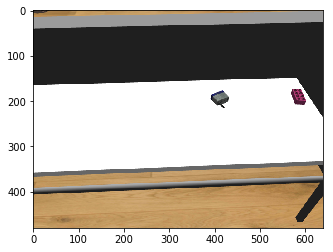

In [22]:
plt.imshow(rgbd.get_image())

In [ ]:
### This server is not  included in launch
###must launch in terminal if wanted
## python <git takeshi_notebooks>/segmentation_2_tf_server/segment_pca_kmeans_2_tf.py 

#service_client_pca = rospy.ServiceProxy('/segment_2_tf', Trigger)
#service_client_pca.wait_for_service(timeout=1.0)


In [ ]:
###PART OF ABOVE'S COMMENT

#res=service_client_pca.call()
#res.message

In [ ]:
#res=service_client_pca.call()
#num_tfs=int(res.message.split()[0])  # ;)

In [ ]:
#for i in range (num_tfs):
    #print listener.lookupTransform('Closest_Object'+str(i),'map',rospy.Time(0))



# run this in terminal (TABLETOP SEGMENTATION )
#  rviz -d `rospack find hsrb_vision_samples`/config/tabletop.rvizro

In [ ]:
""" req = TabletopSegmentationRequest()
    req.crop_enabled = True  # limit the processing area
    req.crop_x_max = 0.7     # X coordinate maximum value in the area [m]
    req.crop_x_min = -0.7    # X coordinate minimum value in the area [m]
    req.crop_y_max = 1.0     # Y coordinate maximum value in the area [m]
    req.crop_y_min = -1.0    # Y coordinate minimum value in the area [m]
    req.crop_z_max = 1.1     # Z coordinate maximum value in the area [m]
    req.crop_z_min = 0.0     # Z coordinate minimum value in the area [m]
    req.cluster_z_max = 1.0  # maximum height value of cluster on table [m]
    req.cluster_z_min = 0.0  # minimum height value of cluster on table [m]
    req.remove_bg = True    # remove the background of the segment image"""

In [23]:

#define a tabletop segmentation request.
# Play with these parameters


req = TabletopSegmentationRequest()
req.crop_enabled = True  # limit the processing area
req.crop_x_max = 0.7     # X coordinate maximum value in the area [m]
req.crop_x_min = -0.7    # X coordinate minimum value in the area [m]
req.crop_y_max = 1.0     # Y coordinate maximum value in the area [m]
req.crop_y_min = -1.0    # Y coordinate minimum value in the area [m]
req.crop_z_max = 1.0     # Z coordinate maximum value in the area [m]
req.crop_z_min = 0.0     # Z coordinate minimum value in the area [m]
req.cluster_z_max = 3  # maximum height value of cluster on table [m]
req.cluster_z_min = 0.0  # minimum height value of cluster on table [m]
req.remove_bg = True    # remove the background of the segment image    THIS IS AN IMPORTANT PARAMETER PLEASE NOTICE

res = service_client(req)
for i in range (len(res.table_array.tables)):
    print (res.table_array.tables[i].pose)

rospy.loginfo('Number of detected objects={0}'.format(
    len(   res.segmented_objects_array.table_objects_array)))
rospy.loginfo('Number of detected planes={0}'.format(
    len(res.table_array.tables)))
#(trans,rot)=tf_listener.lookupTransform('hand_palm_link', 'map', rospy.Time(0)) 

position: 
  x: -0.0255689825863
  y: -0.00511379679665
  z: 0.810000061989
orientation: 
  x: 0.925790309906
  y: -0.000559611187782
  z: -0.0013704636367
  w: 0.378034561872
position: 
  x: 0.0735818445683
  y: 0.18850967288
  z: 0.777000010014
orientation: 
  x: 0.916932344437
  y: -0.0159351713955
  z: 0.0368026532233
  w: -0.397022277117
position: 
  x: -0.0493278428912
  y: -0.283426076174
  z: 0.927000045776
orientation: 
  x: 0.922613382339
  y: -0.0164700616151
  z: 0.0396407730877
  w: -0.383330047131
position: 
  x: 0.0115019837394
  y: 0.390182673931
  z: 0.981000065804
orientation: 
  x: 0.88671040535
  y: -0.000439773168182
  z: -0.000843458634336
  w: 0.462324261665
position: 
  x: -0.11009272933
  y: -0.370458006859
  z: 0.891000032425
orientation: 
  x: 0.928407788277
  y: -0.000237192769418
  z: -0.000592663884163
  w: 0.37156239152
[INFO] [1637365469.353834, 77.016000]: Number of detected objects=5
[INFO] [1637365469.355246, 77.016000]: Number of detected planes=5


('Plane', 0, 'has', 1, 'objects')
('Plane', 1, 'has', 0, 'objects')
('Plane', 2, 'has', 1, 'objects')
('Plane', 3, 'has', 0, 'objects')
('Plane', 4, 'has', 0, 'objects')
[array([ 0.10559922, -0.08524268,  0.87069793]), array([0.08091782, 0.16679964, 0.77343519])]
('images[]', 0)


True

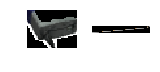

In [24]:
res = service_client(req)
cents,xyz=res_to_cents(res,plt_images=True)
quats= pca_xyz(xyz)
static_tf_publish(cents,quats)


In [25]:
quats= pca_xyz(xyz)
quats

[array([-0.07819017, -0.00342166,  0.40041819,  0.91298404]),
 array([-0.94765938,  0.31513968,  0.03916308,  0.03308995])]

In [26]:
#cents, xyz=seg_pca()
#quats= pca_xyz(xyz)

cents= objs_depth_centroids
static_tf_publish(cents,quats)

NameError: name 'objs_depth_centroids' is not defined

In [27]:
centroids,xyz, images=seg_pca()
quats= pca_xyz(xyz)
static_tf_publish(centroids,quats)

('cX,cY', 282, 354)
[-0.01538096  0.19398275  0.9333491 ]
('cX,cY', 380, 179)
[ 0.09842727 -0.09541436  0.8946297 ]
('cX,cY', 549, 169)
[ 0.3925802  -0.12067978  0.9418291 ]
('images[]', 0)
('images[]', 1)
('images[]', 2)


True

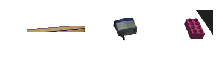

In [28]:
sub_plt=0
for image in images:
    
    sub_plt+=1
    ax = plt.subplot(5, 5, sub_plt )
    
    plt.imshow(image)
    plt.axis("off")

        

# Checkout your rviz. You should be able to see a tf marker on the centroids published above

In [29]:
def gazebo_2_world(x,y):

    x_world= x+2.1
    y_world= -(y-1.2)
    return (x_world,y_world)

def world_2_gazebo(y_world , x_world):

    x= ( x_world - 2.1)
    y= (-y_world + 1.2) 
    return (x , y)

## THIS PATH MUST BE SET BY USER () 


#_path_model = "/home/oscar/Codes/ycb_ws/src/robot_object_views/robotobject/models"   Tenshi Version

_path_model = "/home/oscar/Codes/catkin_mio_ws/src/tmc_wrs_gazebo_world/models"     #Catkin mio version 
#_path_model = "/home/roboworks/Codes/catkin_mio/src/tmc_wrs_gazebo_world/models"     #Catkin mio version 


objs=os.listdir(_path_model)
objs.sort()
print (objs)

['person_standing', 'training_floor', 'training_wall', 'trofast', 'wrc_bin_black', 'wrc_bin_green', 'wrc_bookshelf', 'wrc_container_a', 'wrc_container_b', 'wrc_frame', 'wrc_ground_plane', 'wrc_long_table', 'wrc_stair_like_drawer', 'wrc_tall_table', 'wrc_tray', 'ycb_002_master_chef_can', 'ycb_003_cracker_box', 'ycb_004_sugar_box', 'ycb_005_tomato_soup_can', 'ycb_006_mustard_bottle', 'ycb_007_tuna_fish_can', 'ycb_008_pudding_box', 'ycb_009_gelatin_box', 'ycb_010_potted_meat_can', 'ycb_011_banana', 'ycb_012_strawberry', 'ycb_013_apple', 'ycb_014_lemon', 'ycb_015_peach', 'ycb_016_pear', 'ycb_017_orange', 'ycb_018_plum', 'ycb_019_pitcher_base', 'ycb_021_bleach_cleanser', 'ycb_022_windex_bottle', 'ycb_024_bowl', 'ycb_025_mug', 'ycb_026_sponge', 'ycb_027_skillet', 'ycb_028_skillet_lid', 'ycb_029_plate', 'ycb_030_fork', 'ycb_031_spoon', 'ycb_032_knife', 'ycb_033_spatula', 'ycb_035_power_drill', 'ycb_036_wood_block', 'ycb_037_scissors', 'ycb_038_padlock', 'ycb_040_large_marker', 'ycb_042_adjust

In [54]:
x_gaz,y_gaz= world_2_gazebo(1,1.61)
eu_i,eu_j,eu_k = 3.1416,0,0
spawn_object('spawned',objs[44], x_gaz,  y_gaz,  0.0,eu_i,eu_j,eu_k )


[INFO] [1637365729.054152, 166.023000]: Spawn: ycb_033_spatula
[INFO] [1637365729.063243, 166.023000]: Spawn: [-0.0000000e+00  0.0000000e+00  1.0000000e+00 -3.6732051e-06]
[INFO] [1637365729.068460, 166.029000]: Waiting for service /gazebo/spawn_sdf_model
[INFO] [1637365729.090775, 166.035000]: Calling service /gazebo/spawn_sdf_model
[INFO] [1637365729.585163, 166.224000]: Spawn status: SpawnModel: Successfully spawned entity


In [53]:
delete_object('spawned')

In [ ]:
tf.transformations.quaternion_from_euler(eu_i,eu_j,eu_k)

In [ ]:
gaze_point(1,1,0)
arm.set_named_target('go')
arm.go()

In [ ]:
plt.imshow (rgbd.get_image())

In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=5000,plt_images=True)

In [ ]:
res = service_client(req)

In [ ]:
res_to_cents(res,plt_images=True)

In [ ]:
res = service_client(req)

In [ ]:
res_to_cents(res)

In [ ]:
cents, xyz,images=res_to_cents(res,True)

In [ ]:
quats=pca_xyz(xyz)

In [ ]:
static_tf_publish(cents,quats,'end')

In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=10000,plt_images=True)

In [ ]:
move_base(2,1,np.pi)

In [ ]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=10000,plt_images=True)

In [ ]:
x_gaz,y_gaz= world_2_gazebo(1,1)
eu_i,eu_j,eu_k = .5*np.pi,0,0
spawn_object('spawned',objs[-13], x_gaz,  y_gaz,  0.6,eu_i,eu_j,eu_k )


In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)
quats=pca_xyz(xyz)
static_tf_publish(cents,quats,'at 2,1')

In [ ]:
move_base(1.5,.5,np.pi)

In [ ]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)
quats=pca_xyz(xyz)
static_tf_publish(cents,quats,'at 1.5,.5')

In [ ]:
move_base(1.5,.5,0)

In [ ]:
gaze_point(1,1,.1)
arm.set_named_target('go')
arm.go()

In [ ]:
cents,xyz,images=seg_pca(lower=100,higher=40000,plt_images=True)
quats=pca_xyz(xyz)
static_tf_publish(cents,quats,'at 02,1')